###Analyse

* Wat is het probleem? 
   - voorspellen welk team zal winnen afhankelijk van of ze op een neutrale plek gespeeld zijn (classificatie).
* Wat voor labels heb je?
  - neutral_win( combinatie van home_score,away_score, country)
* Dimensie data set?
  -  Er zijn 9 features en 4163 rijen met de data.
* Soorten data/features?
De features bestaan uit tekst en getallen, de features zijn:
  - De data bestaat vooral uit tekst, data(datum) en cijfers.
Features:
  - date - date of the match
  - home_team - the name of the home team
  - away_team - the name of the away team
  - home_score - full-time home team score - including extra time, not including penalty-shootouts
  - away_score - full-time away team score including extra time, not including penalty-shootouts
  - tournament - the name of the tournament
  - city - the name of the city/town/administrative unit where the match was played
  - country - the name of the country where the match was played
  - neutral - TRUE/FALSE column indicating whether the match was played at a neutral venue




###Voorspelling:
* Welke classifier zal het beste zijn en waarom? 
  * De decision tree, omdat deze over het algemeen goede voorspellingen doet en het goed doet op kleinere datasets. 
* Welke hyperparameters zijn relevant en waarom?
  - De decision tree het max leaf nodes, omdat deze bepaald hoe groot de tree zal worden.
  - De penalty voor logistisc regression: omdat dit zorgt voor minder overfitting.


###Methoden
* Welke preprocessing stappen zijn nodig?
  - De categorische data moet ge-onehotencode worden. Bovendien zal er een kolom moeten worden toegevoegd waarin duidelijk wordt of de thuis-partij gewonnen heeft en ook neutraal was. 
* Welke classifiers ga je vergelijken? (Minimaal 2 per dataset)
  - Logistic regression en de decision tree.
* Welke performance metric is passend?
  - De confusie matrix kan goed laten zien hoeveel true/false positives en true/false negatives er zijn.
  - En de F1 score, dit omdat het een goede weergave is tussen alle true/false positives en true/false negatives.

###Resultaten

*Niet alleen beste resultaat geven, het gaat juist ook om de vergelijking/verbetering!*
* Minimaal 1 visualisatie/plotje per dataset.
* Evaluatie/conclusie
* Welke classifier leverde beste resultaat op?
* Klopt dit met je voorspelling? Waarom wel/niet?

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from scipy import stats
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import linear_model

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import math

%matplotlib inline

In [2]:
# Verover data en bekijk het
df = pd.read_csv("/content/drive/My Drive/minor/ML/women_football.csv", sep =",")
df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1969-11-01,Italy,France,1,0,Euro,Novara,Italy,False
1,1969-11-01,Denmark,England,4,3,Euro,Aosta,Italy,True
2,1969-11-02,England,France,2,0,Euro,Turin,Italy,True
3,1969-11-02,Italy,Denmark,3,1,Euro,Turin,Italy,False
4,1975-08-25,Thailand,Australia,3,2,AFC Championship,Hong Kong,Hong Kong,True


In [3]:
df.shape

(4163, 9)

Als we naar de data kijken en het probleem zullen de kolommen date en city niet veel toegevoegde waarde hebben. 

In [4]:
# Verwijder kolommen die onnodig zijn 
df = df.drop("city",axis=1)
df.head()

,date,home_team,away_team,home_score,away_score,tournament,country,neutral
0,1969-11-01,Italy,France,1,0,Euro,Italy,False
1,1969-11-01,Denmark,England,4,3,Euro,Italy,True
2,1969-11-02,England,France,2,0,Euro,Italy,True
3,1969-11-02,Italy,Denmark,3,1,Euro,Italy,False
4,1975-08-25,Thailand,Australia,3,2,AFC Championship,Hong Kong,True


In [5]:
df['year'] = df['date'].apply(lambda x: x[0:4])
df['month'] = df['date'].apply(lambda x: x[5:7])

df = df.drop('date', axis=1)

In [6]:
# Kijk of er null-waarden zijn
df.isnull().sum()

home_team     0
away_team     0
home_score    0
away_score    0
tournament    0
country       0
neutral       0
year          0
month         0
dtype: int64

In [7]:
df.shape

(4163, 9)

In [8]:
 # Kijk of er categorische data is en vervang deze
cat_data = df.select_dtypes(exclude = [np.number]).columns
print(cat_data)

#Vervang neutral met numerieke data
df['neutral'] = df['neutral'].astype("category").cat.codes
df.head()

Index(['home_team', 'away_team', 'tournament', 'country', 'neutral', 'year',
       'month'],
      dtype='object')


,home_team,away_team,home_score,away_score,tournament,country,neutral,year,month
0,Italy,France,1,0,Euro,Italy,0,1969,11
1,Denmark,England,4,3,Euro,Italy,1,1969,11
2,England,France,2,0,Euro,Italy,1,1969,11
3,Italy,Denmark,3,1,Euro,Italy,0,1969,11
4,Thailand,Australia,3,2,AFC Championship,Hong Kong,1,1975,08


In [9]:
df.drop(columns=['tournament'], inplace=True)

In [10]:
# Voeg een kolom toe met of het thuis team gewonnen heeft
df['home_wins'] = np.where(df['home_score'] > df['away_score'],1,0)
df

,home_team,away_team,home_score,away_score,country,neutral,year,month,home_wins
0,Italy,France,1,0,Italy,0,1969,11,1
1,Denmark,England,4,3,Italy,1,1969,11,1
2,England,France,2,0,Italy,1,1969,11,1
3,Italy,Denmark,3,1,Italy,0,1969,11,1
4,Thailand,Australia,3,2,Hong Kong,1,1975,08,1
...,...,...,...,...,...,...,...,...,...
4158,France,Netherlands,3,3,France,0,2020,03,0
4159,Belgium,Denmark,0,4,Portugal,1,2020,03,0
4160,New Zealand,Norway,1,2,Portugal,1,2020,03,0
4161,England,Spain,0,1,United States,1,2020,03,0


In [11]:
df['neutral_win'] = np.where((df['home_wins'] == 1) & (df['neutral'] == False),0,1)
df

,home_team,away_team,home_score,away_score,country,neutral,year,month,home_wins,neutral_win
0,Italy,France,1,0,Italy,0,1969,11,1,0
1,Denmark,England,4,3,Italy,1,1969,11,1,1
2,England,France,2,0,Italy,1,1969,11,1,1
3,Italy,Denmark,3,1,Italy,0,1969,11,1,0
4,Thailand,Australia,3,2,Hong Kong,1,1975,08,1,1
...,...,...,...,...,...,...,...,...,...,...
4158,France,Netherlands,3,3,France,0,2020,03,0,1
4159,Belgium,Denmark,0,4,Portugal,1,2020,03,0,1
4160,New Zealand,Norway,1,2,Portugal,1,2020,03,0,1
4161,England,Spain,0,1,United States,1,2020,03,0,1


In [12]:
countries = df['country'].unique()
i = np.arange(1, 187, 1).tolist()

countries_enc = {key:value for (key,value) in zip(countries, i)}

df.home_team.replace(countries_enc,inplace = True)
df.away_team.replace(countries_enc,inplace = True)
df.country.replace(countries_enc,inplace = True)
df

,home_team,away_team,home_score,away_score,country,neutral,year,month,home_wins,neutral_win
0,1,15,1,0,1,0,1969,11,1,0
1,16,9,4,3,1,1,1969,11,1,1
2,9,15,2,0,1,1,1969,11,1,1
3,1,16,3,1,1,0,1969,11,1,0
4,20,27,3,2,2,1,1975,08,1,1
...,...,...,...,...,...,...,...,...,...,...
4158,15,13,3,3,15,0,2020,03,0,1
4159,11,16,0,4,18,1,2020,03,0,1
4160,24,7,1,2,18,1,2020,03,0,1
4161,9,23,0,1,41,1,2020,03,0,1


In [13]:
#Maak train en test set
X = df.drop(columns=['neutral_win', 'country', 'home_team', 'away_team'], axis=1)
y = df[['neutral_win']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 6)

<Figure size 432x288 with 0 Axes>

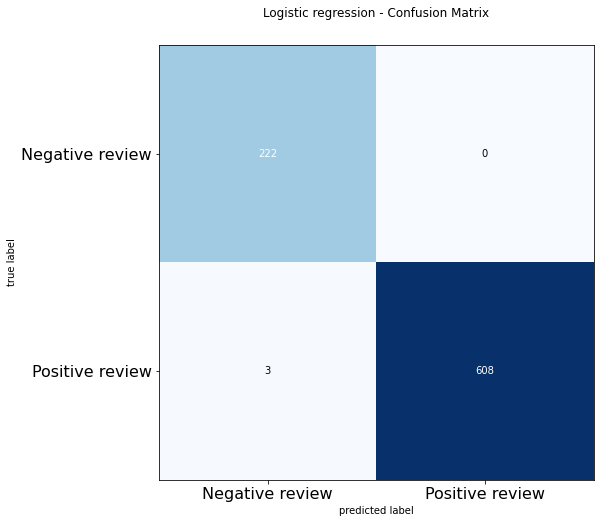

Precision: 1.000000
Recall: 0.995090
F1 score: 0.997539


In [27]:
log_reg = LogisticRegression(penalty='l2')
log_reg.fit(X_train,y_train)
logr_pred=log_reg.predict(X_test)

from sklearn.metrics import confusion_matrix, accuracy_score,precision_score,recall_score,f1_score
from mlxtend.plotting import plot_confusion_matrix

cm = confusion_matrix(y_test, logr_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Logistic regression - Confusion Matrix")
plt.xticks(range(2), ["Negative review","Positive review"], fontsize=16)
plt.yticks(range(2), ["Negative review","Positive review"], fontsize=16)
plt.show()

# precision tp / (tp + fp)
logr_precision = precision_score(y_test, logr_pred)
print('Precision: %f' % logr_precision)

# recall: tp / (tp + fn)
logr_recall = recall_score(y_test, logr_pred)
print('Recall: %f' % logr_recall)

# f1: 2 tp / (2 tp + fp + fn)
logr_f1 = f1_score(y_test, logr_pred)
print('F1 score: %f' % logr_f1)


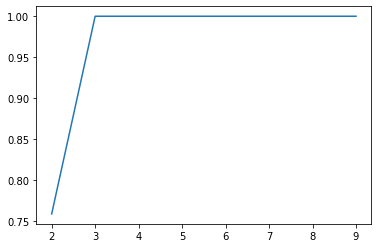

In [28]:
# Finding the optimum number of max_leaf_nodes // from bron 1
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
list1 = []
for leaves in range(2,10):
    classifier = DecisionTreeClassifier(max_leaf_nodes = leaves, random_state=0)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    list1.append(accuracy_score(y_test,y_pred))
plt.plot(list(range(2,10)), list1)
plt.show()

0.758703481392557


<Figure size 432x288 with 0 Axes>

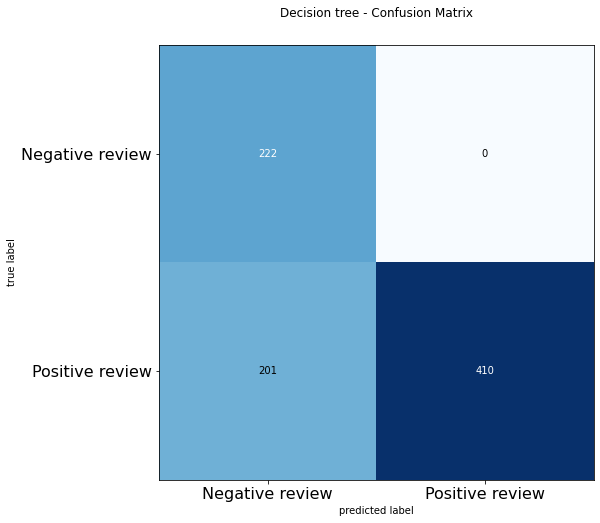

Precision: 1.000000
Recall: 0.671031
F1 score: 0.803134


In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

dtc = DecisionTreeClassifier(max_leaf_nodes=2)
dtc.fit(X_train,y_train)
dtc_pred = dtc.predict(X_test)

print(accuracy_score(y_test, dtc_pred))

cm = confusion_matrix(y_test, dtc_pred)
plt.figure()
plot_confusion_matrix(cm, figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.title("Decision tree - Confusion Matrix")
plt.xticks(range(2), ["Negative review","Positive review"], fontsize=16)
plt.yticks(range(2), ["Negative review","Positive review"], fontsize=16)
plt.show()

# precision tp / (tp + fp)
dtc_precision = precision_score(y_test, dtc_pred)
print('Precision: %f' % dtc_precision)

# recall: tp / (tp + fn)
dtc_f1 = recall_score(y_test, dtc_pred)
print('Recall: %f' % dtc_f1)

# f1: 2 tp / (2 tp + fp + fn)
dtc_f1 = f1_score(y_test, dtc_pred)
print('F1 score: %f' % dtc_f1)

In [30]:
print('F1 score logistic regression: %f' % logr_f1)
print('F1 score decision tree: %f' % dtc_f1)


F1 score logistic regression: 0.997539
F1 score decision tree: 0.803134


## Conclusie

De decision tree leverde het slechtste resultaat op met een f1-score van 0.80.Dit kwam niet overeen met mijn voorspelling.

 De logistische regressie heeft een F1-score van 0.99. Dit is aanzienlijk hoog, waardoor je denkt dat de een linear verband gevonden heeft en zo de beste resultaten heeft behaald. Ook is de decision tree gevoelig voor noise, dus zou dit effect gehad kunnen hebben op de voorspellingen.



Bronnen

- https://www.displayr.com/decision-trees-are-usually-better-than-logistic-regression/
- https://dzone.com/articles/logistic-regression-vs-decision-tree